# Load the data to be used

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PATH_TO_ZIPPED_DATA = 'data/zipped_data/'  # Provide the path to the FDIC/FFIEC's zipped data if you need it extracted
PATH_TO_UNZIPPED_DATA = 'data/used_data'

In [3]:
# It's easier to only load variables you need into the dataframe rather than joining all the reports together;
# that's due to variables being present in multiple reports.
REPORTS_TO_LOAD = {
    'RC': ['RCON3210', 'RCON2170'], # balance sheet
    'RCCI': ['RCON2122', 'RCON1797', 'RCON5367', 'RCON5368'], # loans and leases I
    'RCEI': ['RCON2604', 'RCONJ473', 'RCONJ474'], # deposit liabilities I
    'RCK': ['RCONA514', 'RCON3485', 'RCONB563', 'RCONA529', 'RCON3368'], # quarterly averages
    'RCN': ['RCON2769', 'RCON3492', 'RCON3494', 'RCON3495', 'RCON5399', 'RCON5400', 'RCON5402', 'RCON5403',
            'RCON3500', 'RCON3501', 'RCON3503', 'RCON3504', 'RCONB835', 'RCONB836', 'RCON1607', 'RCON1608',
            'RCONB576', 'RCONB577', 'RCONB579', 'RCONB580', 'RCON5390', 'RCON5391', 'RCON5460', 'RCON5461',
            'RCON1227', 'RCON1228', 'RCON3506', 'RCON3507', 'RCONC237', 'RCONC229', 'RCONC239', 'RCONC230',
            'RCONK214', 'RCONK215', 'RCONK217', 'RCONK218', 'RCONF174', 'RCONF176', 'RCONF175', 'RCONF177',
            'RCONF180', 'RCONF182', 'RCONF181', 'RCONF183'], # past due loans
    'RCO': ['RCON5597', 'RCON2710', 'RCON2722', 'RCONF051', 'RCONF052', 'RCONF047', 'RCONF048', 'RCONG167',
            'RCONG168', 'RCONJ944', 'RCONJ945'], # deposit insurance assessment
    'RI': ['RIADA517', 'RIAD4508', 'RIAD0093', 'RIADA518', 'RIAD4301'], # income statement
    }

DATES_TO_USE = ['03312001', '06302001', '09302001', '12312001',
               '03312002', '06302002', '09302002', '12312002',
               '03312003', '06302003', '09302003', '12312003',
               '03312004', '06302004', '09302004', '12312004',
               '03312005', '06302005', '09302005', '12312005',
               '03312006', '06302006', '09302006', '12312006',
               '03312007', '06302007', '09302007', '12312007',
               '03312008', '06302008', '09302008', '12312008',
               '03312009', '06302009', '09302009', '12312009',
               '03312010', '06302010', '09302010', '12312010',
               '03312011', '06302011', '09302011', '12312011',
               '03312012', '06302012', '09302012', '12312012',
               ]

### Uncomment this if you need to extract files from the FDIC/FFIEC's zipped folders:

In [4]:
# Uncomment to get data in the folder of your choice

#import zipfile

#for report_date in DATES_TO_USE:
#    zipped_folder = zipfile.ZipFile(PATH_TO_ZIPPED_DATA + 'FFIEC CDR Call Bulk All Schedules ' + report_date + '.zip')
#    names_of_files_to_unzip = ['FFIEC CDR Call Schedule ' + report_name + ' ' + report_date + '.txt' \
#                               for report_name in REPORTS_TO_LOAD]

#    for file in names_of_files_to_unzip:
#        try:
#            zipped_folder.extract(file, PATH_TO_UNZIPPED_DATA)
#        except KeyError:
#            try: # RCN breaks into 2 reports in 2011 and gets a new name
#                zipped_folder.extract(file[:-4] + "(1 of 2)" + file[-4:], PATH_TO_UNZIPPED_DATA)
#                zipped_folder.extract(file[:-4] + "(2 of 2)" + file[-4:], PATH_TO_UNZIPPED_DATA)
#            except KeyError:
#                print("There was a problem with file ", file)

# Make dataframes

In [5]:
### Evolution of the FDIC's variables

#Was:    RCON5402, RCON5403                        In RCN, split into 4 categories in March 2002
#Became: RCONC237, RCONC229, RCONC239, RCONC230    The 4 categories RCON5402 and RCON5403 were split into
#Was:    RCONB579, RCONB580                        In RCN, split into 4 categories in March 2011
#Became: RCONK214, RCONK215, RCONK217, RCONK218    The 4 categories RCONB579 and RCONB580 were split into
#Was:    RCON2769, RCON3492                        In RCN, split into 4 categories in March 2008
#Became: RCONF174, RCONF176, RCONF175, RCONF177    The 4 categories RCON2769 and RCON3492 were split into
#Was:    RCON3503, RCON3504                        In RCN, split into 4 categories in March 2008
#Became: RCONF180, RCONF182, RCONF181, RCONF183    The 4 categories RCON3503 and RCON3504 were split into
#Was:    RCON2604                                  In RCEI, split into 3 categories in March 2010
#Became: RCONJ473, RCONJ474                        The 2 relevant categories RCON2604 was split into
#Was:    RCON2710, RCON2722                        In RCO through June 2006, representing the $/# of deposit accounts > $100k, 
                                                    #then turns into...
#Became: RCONF051, RCONF052, RCONF047, RCONF048    The $/# of deposit accounts > 100k and > $250k for retirement accounts
                                                    #Changes again 9/2009 from deposit accounts >$100k to deposit accounts >$250k
#Was:    RCONG167, RCONG168                        The $/# of fully insured transaction accounts. Added 12/31/2008
#Became: RCONJ944, RCONJ945                        The $/# of fully insured transaction accounts. Same thing, different name.

In [6]:
# When variables are missing from reports, it's because the FDIC phased out that variable already,
# or because the variable wasn't used yet. 
MISSING_HEADERS = {
    'RCON5402': 'ALL OTH LNS,1-4FMLY-PAS DU 90 DYS OR',
    'RCON5403': 'ALL OTH LNS,1-4FMLY-NONACCRUAL',
    'RCONC237': 'CLSD-ED LNS:SEC 1 LIENS PA DU 90 MOR',
    'RCONC229': 'CLSD-END LNS:SCRD 1ST LIENS-NONACCRL',
    'RCONC239': 'CLSD-ED LNS:SEC JR LIENS PA DU 90 MO',
    'RCONC230': 'CLSD-ED LNS:SCRD JR LIENS-NONACCRUAL',
    'RCONB579': 'PAST DUE(>=90DAY): OTHER INDIV LOANS',
    'RCONB580': 'PAST DUE(NONACCR): OTHER INDIV LOANS',
    'RCONK214': 'AUTO LN TO IND HH FAM PD 90',
    'RCONK215': 'AUTO LN TO IND HH FAM NONACCRUAL',
    'RCONK217': 'OTHR LN TO IND HH FAM PD 90',
    'RCONK218': 'OTHR LN TO IND HH FAM NONACCRUAL',
    'RCON2769': 'CONSTRUCTN LNS-PAST DUE 90DYS OR MOR',
    'RCON3492': 'CONSTRUCTION LNS-NONACCRUAL',
    'RCONF174': '1-4 FAM RES CNSTRCTN LN PD > 90 DAY',
    'RCONF176': '1-4 FAM RES CNSTRCTN LN NONACCRUAL',
    'RCONF175': 'OTHER CNSTRCTN LN PAST DUE > 90 DAYS',
    'RCONF177': 'OTHER CNSTRCTN LN NONACCRUAL',
    'RCON3503': 'LNS SECD BY NONFARM-PAST DU 90DYS OR',
    'RCON3504': 'LNS SECD BY NONFARM-NONACCRUAL',
    'RCONF180': 'LN SCRD BY OWNR OCCPD NFARM NRES > 9',
    'RCONF182': 'LN SCRD BY OWNR OCCPD NFARM NRES NON',
    'RCONF181': 'LN SCRD BY OTHR NFARM NRES PRPRTY >',
    'RCONF183': 'LN SCRD BY OTHR NFARM NRES PRPRTY NA',
    'RCON2604': 'TIME DEPOSITS GE 100000',
    'RCONJ473': 'TIME DEPOSITS EQ 100K LE 250K',
    'RCONJ474': 'TIME DEPOSITS GT 250K',
    'RCON2710': 'TOTAL DEPOSITS > $100,000',
    'RCON2722': 'TOT DEPS - NUM OF ACCTS > $100,000',
    'RCONF051': 'AMT OF DEP ACCNT MORE THAN $250K',
    'RCONF052': 'NBR OF DEP ACCNT GT $250K',
    'RCONF047': 'AMT RETIREMT DEP ACCTS MOR THAN $250',
    'RCONF048': 'NBR RETIRE DEP ACCNT MOR THAN $250K',
    'RCONG167': 'AMT NONINT ACTS GE 250K',
    'RCONG168': 'NBR NONINT ACT GE 250K',
    'RCONJ944': 'AMT NONINT ACTS GT 250K DODD FRANK A',
    'RCONJ945': 'NBR NONINT ACT GT 250K DODD FRANK AC',
}

In [7]:
def single_period_combined_bank_data(date_to_use, starting_count):
    # The FDIC/FFIEC names their files in this pattern: "FFIEC CDR Call Schedule RCO 03312001.txt"
    # date_to_use is the quarter-end date in the report title: '03312001'
    
    # There are two header rows in the FFIEC's text files. I'm keeping both in the dataframe
    # because the first is the document-searchable field number, and the second is the 
    # human-readable description of the value. 

    base_report_created = False

    for report in REPORTS_TO_LOAD:
        try:
            new_report = pd.read_csv(
                PATH_TO_UNZIPPED_DATA + "/FFIEC CDR Call Schedule " + report + " " + date_to_use + ".txt",
                sep="\t", header=(0, 1), engine='python', index_col=0)
        except FileNotFoundError: 
            # Add any known exceptions here, like RCN changing names in 2011
            new_report = pd.read_csv(
                PATH_TO_UNZIPPED_DATA + "/FFIEC CDR Call Schedule RCN " + date_to_use + "(1 of 2).txt",
                sep="\t", header=(0, 1), engine='python', index_col=0)
            new_report_2 = pd.read_csv(
                PATH_TO_UNZIPPED_DATA + "/FFIEC CDR Call Schedule RCN " + date_to_use + "(2 of 2).txt",
                sep="\t", header=(0, 1), engine='python', index_col=0)
            new_report = new_report.join(new_report_2)

        # Filter the loaded report down to only the variables requested, while keeping a record of the
        # variables that were missing, and inserting '0's as placeholders until we deal with them later.
        present_variables = []
        missing_variables = []
        for var in REPORTS_TO_LOAD[report]:
            if var in new_report:
                present_variables += [var]
            else:
                missing_variables += [var]

        if base_report_created:
            if present_variables:
                base_report = base_report.join(new_report[present_variables])
        else:
            if present_variables:
                base_report = new_report[present_variables]
                base_report_created = True

        if missing_variables:
            # Include the missing variables in the dataframe as 0's. We'll deal with them later.
            for var in missing_variables:
                base_report[var, MISSING_HEADERS[var]] = 0 
                ######### IS THIS STEP WORKING? IS THIS THE COMPLAINT PANDAS HAS FOR SETTING A VAR ON A COPY?

        unaccounted_for_vars = [var for var in missing_variables if var not in MISSING_HEADERS]
        if unaccounted_for_vars:
            # Keep track of any missing variables we haven't accounted for
            variables_to_fix[report + "__" + date_to_use] = unaccounted_for_vars

    # My Q2 2009 data included duplicate. Others may have as well.
    return base_report.drop_duplicates(), variables_to_fix

In [8]:
quarterly_dataframes = ['q1_2001', 'q2_2001', 'q3_2001', 'q4_2001',
                        'q1_2002', 'q2_2002', 'q3_2002', 'q4_2002',
                        'q1_2003', 'q2_2003', 'q3_2003', 'q4_2003',
                        'q1_2004', 'q2_2004', 'q3_2004', 'q4_2004',
                        'q1_2005', 'q2_2005', 'q3_2005', 'q4_2005',
                        'q1_2006', 'q2_2006', 'q3_2006', 'q4_2006',
                        'q1_2007', 'q2_2007', 'q3_2007', 'q4_2007',
                        'q1_2008', 'q2_2008', 'q3_2008', 'q4_2008',
                        'q1_2009', 'q2_2009', 'q3_2009', 'q4_2009',
                        'q1_2010', 'q2_2010', 'q3_2010', 'q4_2010',
                        'q1_2011', 'q2_2011', 'q3_2011', 'q4_2011',
                        'q1_2012', 'q2_2012', 'q3_2012', 'q4_2012']

variables_to_fix = {}
dataframe_dict = {}
    
year_count = 2001
#for period in quarterly_dataframes[:12]:
for period in quarterly_dataframes[::4]:
    df, variables_to_fix = single_period_combined_bank_data('0331' + str(year_count), variables_to_fix)
    dataframe_dict[period] = {'df': df, 'quarter': 1}
    year_count += 1

year_count = 2001
#for period in quarterly_dataframes[12:24]:
for period in quarterly_dataframes[1::4]:
    df, variables_to_fix = single_period_combined_bank_data('0630' + str(year_count), variables_to_fix)
    dataframe_dict[period] = {'df': df, 'quarter': 2}
    year_count += 1

year_count = 2001
#for period in quarterly_dataframes[24:36]:
for period in quarterly_dataframes[2::4]:
    df, variables_to_fix = single_period_combined_bank_data('0930' + str(year_count), variables_to_fix)
    dataframe_dict[period] = {'df': df, 'quarter': 3}
    year_count += 1

year_count = 2001
#for period in quarterly_dataframes[36:]:
for period in quarterly_dataframes[3::4]:
    df, variables_to_fix = single_period_combined_bank_data('1231' + str(year_count), variables_to_fix)
    dataframe_dict[period] = {'df': df, 'quarter': 4}
    year_count += 1


c:\users\aubre\desktop\local_math\jupyter_env\lib\site-packages\ipykernel\__main__.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
# Variables that needed to be processed, but weren't, are in variables_to_fix. Hopefully there's nothing to fix.
assert variables_to_fix == {}

In [10]:
### Add economy-wide variables: 1-year treasuries, GDP growth, GDP deflator

# Make variables that need to be calculated

In [11]:
def create_danger_loans_var(df):
     # Noncurrent loans: 90+ days past due but still accruing, as well as nonaccruals 
    # Basically, loans that are in danger of being written off in the next quarter
    df['calculated_var', 'noncurrent_danger_loans'] = df['RCON2769', 'CONSTRUCTN LNS-PAST DUE 90DYS OR MOR'] \
                                                    + df['RCON3492', 'CONSTRUCTION LNS-NONACCRUAL'] \
                                                    + df['RCONF174', '1-4 FAM RES CNSTRCTN LN PD > 90 DAY'] \
                                                    + df['RCONF176', '1-4 FAM RES CNSTRCTN LN NONACCRUAL'] \
                                                    + df['RCONF175', 'OTHER CNSTRCTN LN PAST DUE > 90 DAYS'] \
                                                    + df['RCONF177', 'OTHER CNSTRCTN LN NONACCRUAL'] \
                                                    + df['RCON3494', 'LNS SECD BY FARMLAND-PAST DUE 90DYS'] \
                                                    + df['RCON3495', 'LNS SECD BY FARMLAND-NONACCRUAL'] \
                                                    + df['RCON5399', 'RVLVG,OPEN-END LNS-PAST DU 90 DYS OR'] \
                                                    + df['RCON5400', 'RVLVG,OPEN-END LNS-NONACCRUAL'] \
                                                    + df['RCON5402', 'ALL OTH LNS,1-4FMLY-PAS DU 90 DYS OR'] \
                                                    + df['RCON5403', 'ALL OTH LNS,1-4FMLY-NONACCRUAL'] \
                                                    + df['RCONC237', 'CLSD-ED LNS:SEC 1 LIENS PA DU 90 MOR'] \
                                                    + df['RCONC229', 'CLSD-END LNS:SCRD 1ST LIENS-NONACCRL'] \
                                                    + df['RCONC239', 'CLSD-ED LNS:SEC JR LIENS PA DU 90 MO'] \
                                                    + df['RCONC230', 'CLSD-ED LNS:SCRD JR LIENS-NONACCRUAL'] \
                                                    + df['RCON3500', 'LNS SECD BY MULTIFAMILY-PST DU 90DYS'] \
                                                    + df['RCON3501', 'LNS SECD BY MULTIFAMILY-NONACCRUAL'] \
                                                    + df['RCON3503', 'LNS SECD BY NONFARM-PAST DU 90DYS OR'] \
                                                    + df['RCON3504', 'LNS SECD BY NONFARM-NONACCRUAL'] \
                                                    + df['RCONF180', 'LN SCRD BY OWNR OCCPD NFARM NRES > 9'] \
                                                    + df['RCONF182', 'LN SCRD BY OWNR OCCPD NFARM NRES NON'] \
                                                    + df['RCONF181', 'LN SCRD BY OTHR NFARM NRES PRPRTY >'] \
                                                    + df['RCONF183', 'LN SCRD BY OTHR NFARM NRES PRPRTY NA'] \
                                                    + df['RCONB835', 'PD GE 90 DAY LN TO DI DERIVED'] \
                                                    + df['RCONB836', 'P/D(NONACCR):LOANS TO DI - DERIVED'] \
                                                    + df['RCON1607', 'PAST DUE (>=90 DAYS): C&I LOANS'] \
                                                    + df['RCON1608', 'PAST DUE (NONACCRUAL):C&I LOANS'] \
                                                    + df['RCONB576', 'PAST DUE(>=90DAY): CREDIT CARD LOANS'] \
                                                    + df['RCONB577', 'PAST DUE(NONACCR): CREDIT CARD LOANS'] \
                                                    + df['RCONB579', 'PAST DUE(>=90DAY): OTHER INDIV LOANS'] \
                                                    + df['RCONB580', 'PAST DUE(NONACCR): OTHER INDIV LOANS'] \
                                                    + df['RCONK214', 'AUTO LN TO IND HH FAM PD 90'] \
                                                    + df['RCONK215', 'AUTO LN TO IND HH FAM NONACCRUAL'] \
                                                    + df['RCONK217', 'OTHR LN TO IND HH FAM PD 90'] \
                                                    + df['RCONK218', 'OTHR LN TO IND HH FAM NONACCRUAL'] \
                                                    + df['RCON5390', 'LNS TO FGN GOV,ETC.-PAS DU 90 DYS OR'] \
                                                    + df['RCON5391', 'LNS TO FGN GOV,ETC.-NONACCRUAL'] \
                                                    + df['RCON5460', 'ALL OTHER LOANS-PAST DU 90 DYS OR MO'] \
                                                    + df['RCON5461', 'ALL OTHER LOANS-NONACCRUAL'] \
                                                    + df['RCON1227', 'P/D(>=90DAY):LEASE FIN REC - DERIVED'] \
                                                    + df['RCON1228', 'P/D(NONACCR):LEASE FIN REC - DERIVED'] \
                                                    + df['RCON3506', 'OTH ASSETS-PAST DUE 90DYS OR MOR,ACG'] \
                                                    + df['RCON3507', 'OTHER ASSETS-NONACCRUAL']

In [12]:
def create_simple_variables(df, quarter):
    # Some variables should be calculated with quarter-end variables:
    df['calculated_var', 'equity_to_assets_ratio'] = df['RCON3210', 'TOTAL EQUITY CAPITAL'] / df['RCON2170', 'TOTAL ASSETS']
    df['calculated_var', 'loans_&_leases_as_%_of_assets'] = df['RCON2122', 'TOT LNS&LEASE LESS UNEARN INC ON LNS'] \
        / df['RCON2170', 'TOTAL ASSETS']

    # Others are better understood with quarterly averages:
    df['calculated_var', 'log_of_total_assets'] = np.where(df['RCON3368', 'QTLY AVG OF TOTAL ASSETS'] > 1,
                                                           np.log10(df['RCON3368', 'QTLY AVG OF TOTAL ASSETS']),
                                                           0)
    # We're annualizing the income portion of the ROA calculation for smoother trends
    df['calculated_var', 'smoothed_return_on_assets'] = (df['RIAD4301', 'INCOME(LOSS) BEFORE INCOME TAXES ETC'] / quarter) * 4 \
        / df['RCON3368', 'QTLY AVG OF TOTAL ASSETS']

    # Uninsured deposits = (deposits over FDIC's insurance limits - large fully insured deposits (aka transaction accounts))
        # / number of accounts with uninsured deposits. Remember that $ amounts are in 1,000s
    df['calculated_var', 'uninsured_deposits'] = np.where(df['RCON5597', 'ESTIMATE OF UNINSURED DEPOSITS'] > 0,
                                                          df['RCON5597', 'ESTIMATE OF UNINSURED DEPOSITS'], 
                                                          (df['RCON2710', 'TOTAL DEPOSITS > $100,000'] \
                                                           + df['RCONF051', 'AMT OF DEP ACCNT MORE THAN $250K'] \
                                                           + df['RCONF047', 'AMT RETIREMT DEP ACCTS MOR THAN $250'] \
                                                           - df['RCONG167', 'AMT NONINT ACTS GE 250K'] \
                                                           - df['RCONJ944', 'AMT NONINT ACTS GT 250K DODD FRANK A'])
                                                           - (100 * df['RCON2722', 'TOT DEPS - NUM OF ACCTS > $100,000'] \
                                                             + 100 * df['RCONF052', 'NBR OF DEP ACCNT GT $250K'] \
                                                             + 250 * df['RCONF048', 'NBR RETIRE DEP ACCNT MOR THAN $250K'] \
                                                             - df['RCONG168', 'NBR NONINT ACT GE 250K'] \
                                                             - df['RCONJ945', 'NBR NONINT ACT GT 250K DODD FRANK AC']))

    # Residential real estate as % of total loans - traditionally a measure of the riskiness of a bank's loan portfolio
        # Includes junior liens, not just first liens. Reasonble people can disagree on whether that's appropriate or not.
    df['calculated_var', 'residential_real_estate_as_%_of_loans'] = (df['RCON1797', 'REVOLVING, OPEN-END LNS SECD BY 1-4F'] \
                                                                     + df['RCON5367', 'ALL OTH LNS SECD BY 1-4FMLY-1ST LIEN'] \
                                                                     + df['RCON5368', 'ALL OTH LNS SECD BY 1-4FMLY-JR LIENS']) \
                                                                     / (df['RCON2122', 'TOT LNS&LEASE LESS UNEARN INC ON LNS'])

In [13]:
# Somtimes the names of variables change slightly. When that happens, combine values into the original title

### THIS SECTION NEEDS MORE LOVE. WHAT'S UP WITH THE $ AMOUNTS CHANGING IN THE SAME VARIABLE NAME? MAKE A NEW VARIABLE?

def combine_columns(df):
    if 'PAST DUE GE 90DAY OTHER INDIV LOANS' in df['RCONB579']:
        df['RCONB579', 'PAST DUE(>=90DAY): OTHER INDIV LOANS'] = df['RCONB579', 'PAST DUE GE 90DAY OTHER INDIV LOANS'].copy()
    if 'AMT OF OTH DEP ACCTS MORE THAN $100,' in df['RCONF051']:
        df['RCONF051', 'AMT OF DEP ACCNT MORE THAN $250K'] = df['RCONF051', 'AMT OF OTH DEP ACCTS MORE THAN $100,'].copy()
    if 'NBR OF DEP ACCTS OF MOR THN $100,000' in df['RCONF052']:
        df['RCONF052', 'NBR OF DEP ACCNT GT $250K'] = df['RCONF052', 'NBR OF DEP ACCTS OF MOR THN $100,000'].copy()
    if 'NBR RETIREMT DEP ACCTS MOR THAN $250' in df['RCONF048']:
        df['RCONF048', 'NBR RETIRE DEP ACCNT MOR THAN $250K'] = df['RCONF048', 'NBR RETIREMT DEP ACCTS MOR THAN $250'].copy()
    if '1-4  FAM RES CNSTRCTN LN PD > 90 DAY' in df['RCONF174']: # 2 spaces between "1-4  FAM..."
        df['RCONF174', '1-4 FAM RES CNSTRCTN LN PD > 90 DAY'] = df['RCONF174', '1-4  FAM RES CNSTRCTN LN PD > 90 DAY'].copy()
    if '1-4  FAM RES CNSTRCTN LN NONACCRUAL' in df['RCONF176']:  # 2 spaces between "1-4  FAM..."
        df['RCONF176', '1-4 FAM RES CNSTRCTN LN NONACCRUAL'] = df['RCONF176', '1-4  FAM RES CNSTRCTN LN NONACCRUAL']
    if 'LN SCRD BY OTHR NFARM NRES PRPRTY > ' in df['RCONF181']: # 1 space after ">"
        df['RCONF181', 'LN SCRD BY OTHR NFARM NRES PRPRTY >'] = df['RCONF181', 'LN SCRD BY OTHR NFARM NRES PRPRTY > ']

In [14]:
def make_series_from_comparison_df_to_match_original_df(original_df, comparison_df, var_code, var_name):
    # When doing math on a column in a dataframe with a column from another dataframe,
    # you need to make sure that the indexes match between the two dataframes.
    # This function takes the comparison dataframe, turns the variable of interest into a 1-column dataframe,
    # then forces that dataframe's index to match the original dataframe's index, replacing unknowns with 0s.

    # First, make a new dataframe for the comparison quarter's value:
    comparison_series = pd.DataFrame(
        data = {(var_code, var_name): comparison_df[var_code, var_name]},
        index = comparison_df.index)

    # Find indexes unique to prior_quarter_df to remove them from the combined dataframe:
    indexes_unique_to_comp_df = [item for item in list(comparison_series.index) if item not in list(original_df.index)]
    comparison_series = comparison_series.drop(indexes_unique_to_comp_df)

    # Add additional rows for indexes that are in the original df, but not the comparison df, to the original df:
    unique_to_new_df = [item for item in list(original_df.index) if item not in list(comparison_series.index)]
    new_indexes_as_zeros = pd.DataFrame(
        data = {(var_code, var_name): [0 for item in range(len(unique_to_new_df))]},
        index = unique_to_new_df)

    # Add the dataframes together:
    return pd.concat([comparison_series, new_indexes_as_zeros])

In [15]:
def create_jumbo_interest_margin(df, prior_quarter_df):
    # Average jumbo interest rate. Also is the uninsured interest rate while the FDIC insured accounts >$100k
    # (Interest expense on time deposits >$100k) / (Average $ amount held in time deposits >$100k)
    if isinstance(prior_quarter_df, pd.DataFrame):

        # Make a comparison dataframe to use to difference variables
        one_column_only = make_series_from_comparison_df_to_match_original_df(
            df, prior_quarter_df, 'RIADA517', 'TIME DEPOSITS OF $100,000 OR MORE')

        # Subtract the prior quarter's value from the current dataframe
        df['_temp_var', '_jumbo_interest_rate'] = np.where(
            df['RCONA514', 'QTR AVG TIME DEPOSITS >= $100,000'] > 0,
            (df['RIADA517', 'TIME DEPOSITS OF $100,000 OR MORE'].add(
                -one_column_only['RIADA517', 'TIME DEPOSITS OF $100,000 OR MORE'], fill_value=0)) \
            / df['RCONA514', 'QTR AVG TIME DEPOSITS >= $100,000'],
            0)

        # Weighted average interest rate on jumbo CDs across all banks:
        weighted_avg_jumbo_cd_rate = (
            df['RIADA517', 'TIME DEPOSITS OF $100,000 OR MORE'].sum() \
            - prior_quarter_df['RIADA517', 'TIME DEPOSITS OF $100,000 OR MORE'].sum()) \
            / df['RCONA514', 'QTR AVG TIME DEPOSITS >= $100,000'].sum()

    else:
        df['_temp_var', '_jumbo_interest_rate'] = np.where(
            df['RCONA514', 'QTR AVG TIME DEPOSITS >= $100,000'] > 0,
            df['RIADA517', 'TIME DEPOSITS OF $100,000 OR MORE'] \
            / df['RCONA514', 'QTR AVG TIME DEPOSITS >= $100,000'],
            0)
        
        # Weighted average interest rate on jumbo CDs across all banks:
        weighted_avg_jumbo_cd_rate = df['RIADA517', 'TIME DEPOSITS OF $100,000 OR MORE'].sum() \
            / df['RCONA514', 'QTR AVG TIME DEPOSITS >= $100,000'].sum()     

    # Jumbo Interest Margin: the difference between a particular bank's interest rate on jumbo CDs and
    # the industry's weighted average interest rate on jumbo CDs
    df['calculated_var', 'jumbo_interest_margin'] = df['_temp_var', '_jumbo_interest_rate'] - weighted_avg_jumbo_cd_rate

In [16]:
def _average_total_deposits(df):
    return df['RCON3485', 'QTLY AVG OF INT-BRG TRANSACTION ACCT'] \
         + df['RCONB563', 'QTR AVG: NONTRANS - SAVING DEPOSITS'] \
         + df['RCONA514', 'QTR AVG TIME DEPOSITS >= $100,000'] \
         + df['RCONA529', 'QTR AVG TIME DEPOSITS < $100,000']

def _interest_paid_for_deposits(df):
    return df['RIAD4508', 'INT ON TRANS ACCTS(NOW,ATS&TELEPHON)'] \
         + df['RIAD0093', 'INTEREST EXPENSE ON SAVING DEPOSITS'] \
         + df['RIADA517', 'TIME DEPOSITS OF $100,000 OR MORE'] \
         + df['RIADA518', 'TIME DEPOSITS OF LESS THAN $100,000']

def _add_interest_paid_for_deposits(df):
    df['calculated_var', 'total_interest_paid_for_deposits'] = \
        df['RIAD4508', 'INT ON TRANS ACCTS(NOW,ATS&TELEPHON)'] \
        + df['RIAD0093', 'INTEREST EXPENSE ON SAVING DEPOSITS'] \
        + df['RIADA517', 'TIME DEPOSITS OF $100,000 OR MORE'] \
        + df['RIADA518', 'TIME DEPOSITS OF LESS THAN $100,000']
    return df

def _sum_average_total_deposits(df):
    return df['RIAD4508', 'INT ON TRANS ACCTS(NOW,ATS&TELEPHON)'].sum() \
         + df['RIAD0093', 'INTEREST EXPENSE ON SAVING DEPOSITS'].sum() \
         + df['RIADA517', 'TIME DEPOSITS OF $100,000 OR MORE'].sum() \
         + df['RIADA518', 'TIME DEPOSITS OF LESS THAN $100,000'].sum()

def _sum_interest_paid_for_deposits(df):
    return df['RIAD4508', 'INT ON TRANS ACCTS(NOW,ATS&TELEPHON)'].sum() \
         + df['RIAD0093', 'INTEREST EXPENSE ON SAVING DEPOSITS'].sum() \
         + df['RIADA517', 'TIME DEPOSITS OF $100,000 OR MORE'].sum() \
         + df['RIADA518', 'TIME DEPOSITS OF LESS THAN $100,000'].sum()

def create_deposit_interest_margin(df, prior_quarter_df):
    # This is the difference between a particular bank's interest rates for deposits and the industry average
    # Includes transaction accounts & savings accounts:
    # (Interest expense on transaction + savings accounts + jumbo CDs + non-jumbo CDs) / (Average total deposits)

    if isinstance(prior_quarter_df, pd.DataFrame):
        # Make a comparison dataframe to use to difference variables
        one_column_only = make_series_from_comparison_df_to_match_original_df(
            _add_interest_paid_for_deposits(df), _add_interest_paid_for_deposits(prior_quarter_df),
            'calculated_var', 'total_interest_paid_for_deposits')
        
        df = _add_interest_paid_for_deposits(df)
        
        df['_temp_var', '_deposit_interest_rate'] = np.where(
            _average_total_deposits(df) > 0,
            df['calculated_var', 'total_interest_paid_for_deposits'].add(
                -one_column_only['calculated_var', 'total_interest_paid_for_deposits'], fill_value=0) \
                / _average_total_deposits(df),
            0)

        ########### THIS MUST BE THE BROKEN PART!!!  #########

        # Weighted average interest rate on all deposits, across all banks
        weighted_avg_deposit_interest_margin = (
            _sum_interest_paid_for_deposits(df) - _sum_interest_paid_for_deposits(prior_quarter_df)) \
            / _sum_average_total_deposits(df)

    else:
        df['_temp_var', '_deposit_interest_rate'] = np.where(
            _average_total_deposits(df) > 0,
            _interest_paid_for_deposits(df) / _average_total_deposits(df),
            0)

        # Weighted average interest rate on all deposits, across all banks
        weighted_avg_deposit_interest_margin = _sum_interest_paid_for_deposits(df) / _sum_average_total_deposits(df)

    # Deposit Interest Margin: the difference between a particular bank's average interest rate paid on deposits
    # and the industry's weighted average interest rate paid on deposits
    df['calculated_var', 'deposit_interest_margin'] = df['_temp_var', '_deposit_interest_rate'] \
                                                    - weighted_avg_deposit_interest_margin


In [44]:
## Testing here...

# Make a copy (df.copy(deep=True)) of df and prior_quarter_df. 
# Look at weighted_avg_deposit_interest_margin. Play with that equation and figure out what parts are broken!
# Why is the data still showing so much effect from quarters?
q1_dfs = [df for df in quarterly_dataframes if df.startswith("q1")]
print("Count:", len(q1_dfs))
print("V1:", q1_dfs[0])
#print("V2:", dataframe_dict)

### The format is that the full dict, dataframe_dict, is a dictionary where the keys are things like "q1_2001".
### So what I'm really trying to make a copy of is either the full dataframe_dict, or the key containing
### the dataframe that I want to pass into the functions below, and really just the last function.

#copy_df = q1_dfs[0].copy(deep=True)

#calculate_and_add_variables(copy_df['df'], 1)
#create_jumbo_interest_margin(copy_df['df'], False)
#create_deposit_interest_margin(copy_df['df'], False)  ### The one that matters


Count: 12
V1: q1_2001


In [ ]:
## Tesing here...
# Look at what just got created and figure out why it's negative



In [18]:
def calculate_quarterly_ROA(df, prior_quarter_df):
    # We have another variable called smoothed_return_on_assets. That version takes the year-to-date income numbers,
    # scales them up as if they were a full year's income (4 * (income / quarter number)), which gives a smoother result.
    # Instead, here we're going to treat each quarter individually and scale up that quarter's ROA to an annualized number.

    if isinstance(prior_quarter_df, pd.DataFrame):
        prior_quarter_matching_var = make_series_from_comparison_df_to_match_original_df(
            df, prior_quarter_df, 'RIAD4301', 'INCOME(LOSS) BEFORE INCOME TAXES ETC')
        df['calculated_var', 'quarterly_return_on_assets'] = np.where(
            df['RCON3368', 'QTLY AVG OF TOTAL ASSETS'] > 0,
            df['RIAD4301', 'INCOME(LOSS) BEFORE INCOME TAXES ETC'].add(
                -prior_quarter_matching_var['RIAD4301', 'INCOME(LOSS) BEFORE INCOME TAXES ETC'])
                / df['RCON3368', 'QTLY AVG OF TOTAL ASSETS'],
            0)

    else:
        df['calculated_var', 'quarterly_return_on_assets'] = np.where(
            df['RCON3368', 'QTLY AVG OF TOTAL ASSETS'] > 0,
            df['RIAD4301', 'INCOME(LOSS) BEFORE INCOME TAXES ETC'] / df['RCON3368', 'QTLY AVG OF TOTAL ASSETS'],
            0)

In [19]:
def calculate_and_add_variables(df, quarter):
    combine_columns(df)
    create_simple_variables(df, quarter)
    create_danger_loans_var(df)

## Run all the functions to add variables to the dataframes

In [20]:
# Some operations need to be aware of their prior period. Those have to be done chronologically:
q1_dfs = [df for df in quarterly_dataframes if df.startswith("q1")]
other_dfs = [df for df in quarterly_dataframes if df not in q1_dfs]

# First do all first quarter dataframes
for period in q1_dfs:
    calculate_and_add_variables(dataframe_dict[period]['df'], 1)
    create_jumbo_interest_margin(dataframe_dict[period]['df'], False)
    create_deposit_interest_margin(dataframe_dict[period]['df'], False)
    calculate_quarterly_ROA(dataframe_dict[period]['df'], False)

count=1
for period in other_dfs:
    # Find the prior quarter's dataframe
    if other_dfs.index(period) % 3 == 0:
        # If it's the 2nd quarter, then the prior quarter is in q1_dfs
        prior_quarter_df = q1_dfs[other_dfs.index(period) // 3]
    else:
        # Otherwise it's the item before the current one in other_dfs
        prior_quarter_df = other_dfs[other_dfs.index(period) - 1]

    calculate_and_add_variables(dataframe_dict[period]['df'], dataframe_dict[period]['quarter'])
    create_jumbo_interest_margin(dataframe_dict[period]['df'], dataframe_dict[prior_quarter_df]['df'])
    create_deposit_interest_margin(dataframe_dict[period]['df'], dataframe_dict[prior_quarter_df]['df'])
    calculate_quarterly_ROA(dataframe_dict[period]['df'], dataframe_dict[prior_quarter_df]['df'])
    count += 1


c:\users\aubre\desktop\local_math\jupyter_env\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in log10


In [21]:
## May need to add different variables for international banks...

# Inspect variables via graphs

In [22]:
def plot_sums_over_time(dataframe_dict, variable_code, variable_description, quarterly=False):
    var_sums = []
    # Get the averages for the variable
    for quarter_end in quarterly_dataframes:
        var_sums += [dataframe_dict[quarter_end]['df'][variable_code, variable_description].sum()]

    if quarterly:
        plt.plot(list(range(len(quarterly_dataframes[3::4]))), var_sums[3::4])
    else:
        plt.plot(list(range(len(quarterly_dataframes))), var_sums)
    plt.show()

### Uncomment to look at your variable of choice

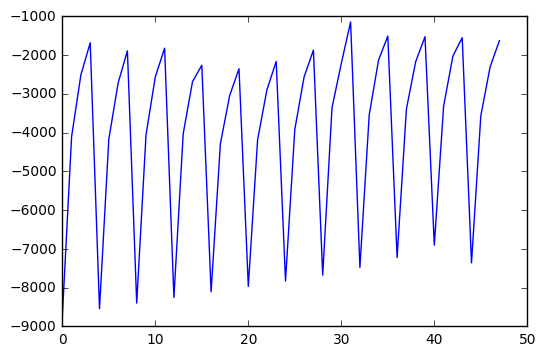

In [34]:
# Plot important variables to make sure they seem believable.
# Often aggregating variables doesn't make a meaningful number. We're watching for discontinuities, dramatic jumps, etc

# GOOD
#plot_sums_over_time(dataframe_dict, 'calculated_var', 'noncurrent_danger_loans')
#plot_sums_over_time(dataframe_dict, 'calculated_var', 'equity_to_assets_ratio')
#plot_sums_over_time(dataframe_dict, 'calculated_var', 'loans_&_leases_as_%_of_assets')
#plot_sums_over_time(dataframe_dict, 'calculated_var', 'smoothed_return_on_assets') ## Not a meaningful number itself
#plot_sums_over_time(dataframe_dict, 'calculated_var', 'residential_real_estate_as_%_of_loans')
#plot_sums_over_time(dataframe_dict, 'calculated_var', 'log_of_total_assets') ## Not a meaningful number itself
#plot_sums_over_time(dataframe_dict, '_temp_var', '_jumbo_interest_rate', quarterly=False)
#plot_sums_over_time(dataframe_dict, 'calculated_var', 'jumbo_interest_margin')
#plot_sums_over_time(dataframe_dict, 'calculated_var', 'quarterly_return_on_assets', quarterly=False)  ## Why do some years show a quarterly trend?

# WEIRD
#plot_sums_over_time(dataframe_dict, '_temp_var', '_deposit_interest_rate')  ## Looks good, but...
plot_sums_over_time(dataframe_dict, 'calculated_var', 'deposit_interest_margin')  #### WHAT THE HELL ARE THESE NEGATIVE NUMBERS?

## Uninsured deposits went up during the recession? The sudden cliffs are, I believe, due to changing FDIC standards.
## Should never be able to be less than 0, but ~1% are! 
#plot_sums_over_time(dataframe_dict, 'calculated_var', 'uninsured_deposits')  

In [ ]:
#dataframe_dict['q1_2010']['df']['calculated_var', 'uninsured_deposits'].describe()
dataframe_dict['q1_2010']['df']['calculated_var', 'uninsured_deposits'].lt(0).sum().sum()

In [ ]:
# Need to make a multi-index dataframe, using dates as the index. 
# How to turn dates into things that pandas understand?
# Have to do that anyways for the actual regression!

# 2 ways to do this:
    # Grab the sum of each variable of interest from the individual dataframe.
    # Look at the original list that keys for the dict of dataframes was made from.
    # For each variable of interest, make a new array tracking the variable over time.
    # Graph the array.

    # Make the dataframe a multi-index dataframe.
    # Do something smart with that. 

In [ ]:
## Difference the variables to get them ready for the GMM

In [ ]:
# Multi-year comparisons:
    # asset growth
    # change in advertising/marketing (RIAD0497)
    
    

In [ ]:
## Variable options: instead of total equity, consider total risk-based equity (RCON3792)

In [ ]:
## Use R's GMM estimation
    # Trying to predict changes in uninsured deposits based on asset quality, general bank health, & deposit rates
    # Try to predict changes in both uninsured & insured deposits (or total deposits?)

In [ ]:
## Check out the fit measurements

In [ ]:
## Incorporate some other model? Random forests, neural networks, regular linear regression, etc?
## Something to show that Arellano-Bond is the right method to use for this problem